# Enrichment from Docking
4th Apr 2022 

This notebook is for parsing an `.sdf` file of docking scores and calculating the enrichment from just using dock scores.

In [1]:
import pandas as pd
from distutils.util import strtobool

from rdkit.Chem import PandasTools


INFO:rdkit:Enabling RDKit 2020.09.1 jupyter extensions


Parse `.sdf`

In [2]:
sdfFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/COVID_Moonshot_activity data_2021-03-22_noncovalent_docked.sdf'
df_docking = PandasTools.LoadSDF(
    sdfFile, idName='canonical_CID', molColName=None)

Filter out covalent columns

In [3]:
df_docking = df_docking.dropna(subset=['acrylamide'])
df_docking['acrylamide'] = df_docking['acrylamide'].apply(
    strtobool).astype(bool)
df_docking['chloroacetamide'] = df_docking['chloroacetamide'].apply(
    strtobool).astype(bool)

df_docking = df_docking.query('~chloroacetamide & ~acrylamide')
columns_to_keep = ['canonical_CID', 'Chemgauss4 Score', 'f_avg_IC50']
df_docking = df_docking[columns_to_keep]

In [4]:
df_docking.f_avg_IC50 = df_docking.f_avg_IC50.astype(float)
df_docking['Chemgauss4 Score'] = df_docking['Chemgauss4 Score'].astype(float)


In [5]:
df_docking_grouped = df_docking.groupby(by=df_docking.canonical_CID).mean()
mean_docking_scores = df_docking_grouped['Chemgauss4 Score'].values
ic50_values = df_docking_grouped['f_avg_IC50'].values


df_docking_grouped['hit'] = df_docking_grouped['f_avg_IC50'] < 5
print(df_docking_grouped[['hit', 'f_avg_IC50']])

                       hit  f_avg_IC50
canonical_CID                         
AAR-POS-0daf6b7e-23  False         NaN
AAR-POS-5507155c-1   False     99.5000
AAR-POS-8a4e0f60-1   False         NaN
AAR-POS-8a4e0f60-10  False         NaN
AAR-POS-8a4e0f60-2   False         NaN
...                    ...         ...
WIL-MOD-03b86a88-2   False     19.0909
WIL-MOD-03b86a88-4   False     15.9534
WIL-MOD-03b86a88-5   False     21.7972
WIL-MOD-03b86a88-6   False     11.2566
WIL-UNI-2e73223c-4   False     99.5000

[1585 rows x 2 columns]


Let's plot the enrichment! (just within moonshot molecules)

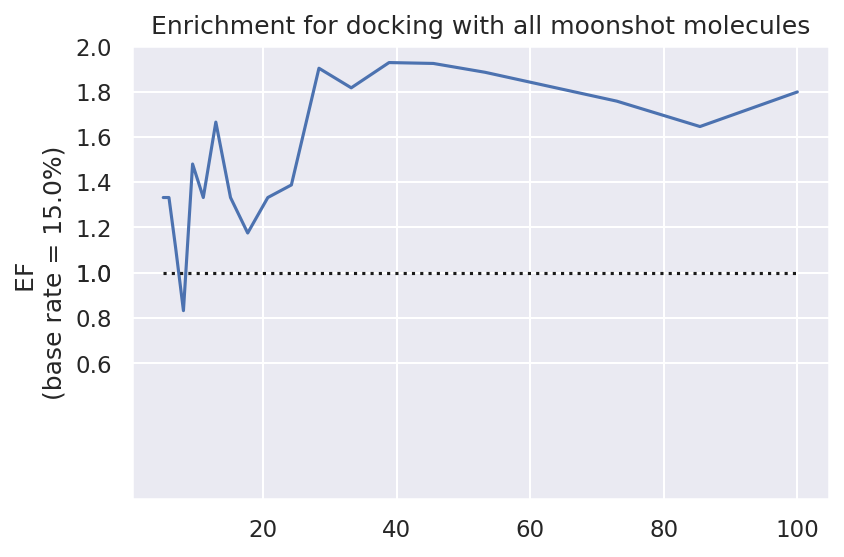

In [48]:
import numpy as np
from fresco.frag_funcs import calculate_enrichment_for_df
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.dpi": 150})

def plot_enrichment(df_to_plot, title='Not Specified!'):
    n_list = np.logspace(start=np.log10(5), stop=2, num=20)  
    EF_docking = [calculate_enrichment_for_df(
        df_to_plot, n=int(n), index='hit', score='Chemgauss4 Score') for n in n_list]

    orig_prop = len(
        df_to_plot[df_to_plot['hit']])/len(df_to_plot)
    plt.plot(n_list, EF_docking)
    plt.plot(n_list, np.ones_like(n_list), 'k:')
    plt.title(f'Enrichment for {title}')
    plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
    extraticks = [1]
    plt.yticks(list(plt.yticks()[0]) + extraticks)
    plt.ylim(bottom=0)


plot_enrichment(df_docking_grouped, title='docking with all moonshot molecules')


Let's get the date of these files

In [7]:
dateFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/20220122_moonshot_submissions_data_for_alpha.csv'
df_date = pd.read_csv(dateFile)
print(df_date)


         submission_id  num_mols  \
0     ALP-POS-a9ad2217         2   
1     ALF-EVA-a24cc7ce         8   
2     PET-UNK-158bee2a        17   
3     EDJ-MED-e9a22d5d         2   
4     EDJ-MED-343bb62d         4   
...                ...       ...   
2647  CAN-UNK-685b6099         1   
2648  EDJ-MED-3707c4bc         3   
2649  PET-UNK-7b413b46        15   
2650  EDJ-MED-0d144977         5   
2651  EDJ-MED-4cb9dd84         4   

                                            contributor  year month_name  day  \
0                      Contributor: Alpha Lee, PostEra   2021        May   13   
1     Contributor: Alfie Brennan, Evariste Technolog...  2021        May   13   
2                             Contributor: Peter Kenny   2021        May   12   
3            Contributor: Ed J Griffen, MedChemica Ltd   2021        May   12   
4            Contributor: Ed J Griffen, MedChemica Ltd   2021        May   12   
...                                                 ...   ...        ...  ...   


Merge dataframe of dock scores with submission dates

In [9]:
def remove_suffix(id):
    id_separated = id.split('-')[:-1]
    new_id = '-'.join(id_separated)
    return new_id


df_docking_grouped['canonical_CID'] = df_docking_grouped.index
df_docking_grouped['submission_id'] = df_docking_grouped['canonical_CID'].apply(remove_suffix)
print(df_docking_grouped)
df_merged = df_docking_grouped.merge(df_date, on='submission_id')
print(df_merged)


                     Chemgauss4 Score  f_avg_IC50    hit        canonical_CID  \
canonical_CID                                                                   
AAR-POS-0daf6b7e-23          -5.71945         NaN  False  AAR-POS-0daf6b7e-23   
AAR-POS-5507155c-1           -5.24347     99.5000  False   AAR-POS-5507155c-1   
AAR-POS-8a4e0f60-1           -9.23545         NaN  False   AAR-POS-8a4e0f60-1   
AAR-POS-8a4e0f60-10          -6.75070         NaN  False  AAR-POS-8a4e0f60-10   
AAR-POS-8a4e0f60-2           -9.57557         NaN  False   AAR-POS-8a4e0f60-2   
...                               ...         ...    ...                  ...   
WIL-MOD-03b86a88-2           -8.93996     19.0909  False   WIL-MOD-03b86a88-2   
WIL-MOD-03b86a88-4           -9.98616     15.9534  False   WIL-MOD-03b86a88-4   
WIL-MOD-03b86a88-5           -9.32327     21.7972  False   WIL-MOD-03b86a88-5   
WIL-MOD-03b86a88-6           -9.12435     11.2566  False   WIL-MOD-03b86a88-6   
WIL-UNI-2e73223c-4          

Plot enrichment as a function of time

False    920
True      59
Name: hit, dtype: int64


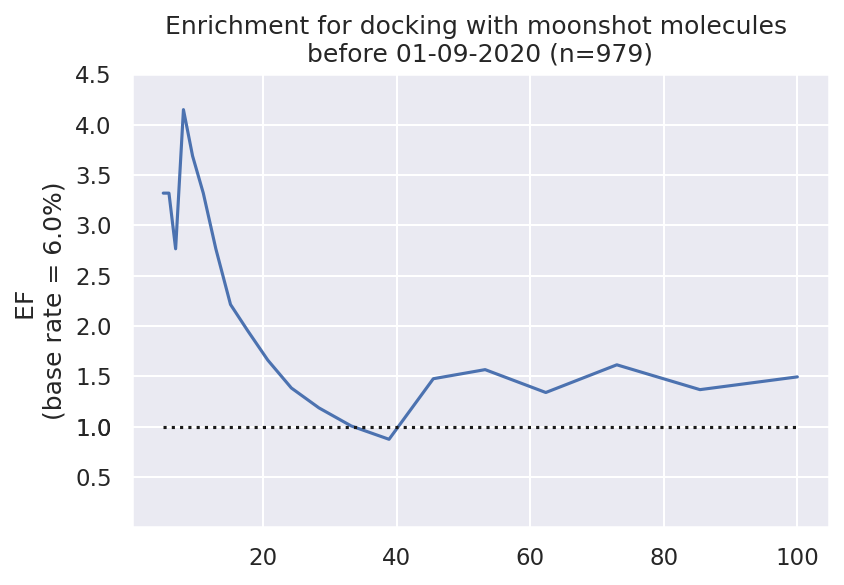

In [52]:
year='2020'
month='09'
day='01'
date_to_filter = int(f'{year}{month}{day}')
df_filtered_by_date = df_merged.query('date < @date_to_filter')
print(df_filtered_by_date['hit'].value_counts())
plot_enrichment(df_filtered_by_date,
                title=f'docking with moonshot molecules \nbefore {day}-{month}-{year} (n={len(df_filtered_by_date)})')


In [ ]:
activityFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/activity_data.csv'
df_activity = pd.read_csv(activityFile)
df_activity


In [ ]:
df_merged = df_docking.merge(df_activity, on='canonical_CID')
print(df_merged)